In [1]:
!kaggle competitions files carvana-image-masking-challenge

name                        size  creationDate         
-------------------------  -----  -------------------  
train_masks.csv.zip         15MB  2018-06-22 02:52:10  
train_hq.zip               804MB  2018-06-22 02:52:10  
29bb3ece3180_11.jpg        107KB  2018-06-22 02:52:10  
train_masks.zip             29MB  2018-06-22 02:52:10  
metadata.csv.zip            81KB  2018-06-22 02:52:10  
train.zip                  405MB  2018-06-22 02:52:10  
sample_submission.csv.zip  202KB  2018-06-22 02:52:10  
test.zip                     8GB  2018-06-22 02:52:10  
test_hq.zip                 15GB  2018-06-22 02:52:10  


In [3]:
!kaggle competitions download carvana-image-masking-challenge -f train.zip
!kaggle competitions download carvana-image-masking-challenge -f train_masks.zip


 98%|████████████████████████████████████████▎| 398M/405M [00:03<00:00, 111MB/s]
100%|█████████████████████████████████████████| 405M/405M [00:03<00:00, 108MB/s]
 89%|█████████████████████████████████▉    | 26.0M/29.1M [00:00<00:00, 70.3MB/s]
100%|██████████████████████████████████████| 29.1M/29.1M [00:00<00:00, 75.0MB/s]


In [4]:
!unzip '*.zip'

Archive:  train.zip
   creating: train/
  inflating: train/00087a6bd4dc_01.jpg  
  inflating: train/00087a6bd4dc_02.jpg  
  inflating: train/00087a6bd4dc_03.jpg  
  inflating: train/00087a6bd4dc_04.jpg  
  inflating: train/00087a6bd4dc_05.jpg  
  inflating: train/00087a6bd4dc_06.jpg  
  inflating: train/00087a6bd4dc_07.jpg  
  inflating: train/00087a6bd4dc_08.jpg  
  inflating: train/00087a6bd4dc_09.jpg  
  inflating: train/00087a6bd4dc_10.jpg  
  inflating: train/00087a6bd4dc_11.jpg  
  inflating: train/00087a6bd4dc_12.jpg  
  inflating: train/00087a6bd4dc_13.jpg  
  inflating: train/00087a6bd4dc_14.jpg  
  inflating: train/00087a6bd4dc_15.jpg  
  inflating: train/00087a6bd4dc_16.jpg  
  inflating: train/02159e548029_01.jpg  
  inflating: train/02159e548029_02.jpg  
  inflating: train/02159e548029_03.jpg  
  inflating: train/02159e548029_04.jpg  
  inflating: train/02159e548029_05.jpg  
  inflating: train/02159e548029_06.jpg  
  inflating: train/02159e548029_07.jpg  
  inflating: trai

In [34]:
# importing packages
import sagemaker
import boto3
import os
from sagemaker.pytorch import PyTorch
import torch

In [35]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = "us-east-1"
bucket = "the-data-image-segmentation"
train = "s3://{}/{}/{}".format(bucket, "images1","train")
val = "s3://{}/{}/{}".format(bucket, "images1","val")
train_masks = "s3://{}/{}/{}".format(bucket, "images1","train_masks")
val_masks = "s3://{}/{}/{}".format(bucket, "images1","val_masks")
output_dir = "s3://the-data-image-segmentation/inference-output/"

In [4]:
# Declare HP ranges
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64]), # Because over 64 batchsize will result in GPU Memory insufficient
    "epochs" : IntegerParameter(5,50)
}
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [5]:
estimator = PyTorch(
    entry_point="hpo.py",
    source_dir = "src",
    base_job_name = 'UNET-HPO',
    role=role,
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    py_version='py3',
    framework_version="1.4.0",
    )
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [ ]:

tuner.fit({'train' : train, 'val' : val, 'train_masks' : train_masks, 'val_masks' : val_masks }, wait=True)

............................................................................................................

In [6]:
from sagemaker.debugger import ProfilerRule, rule_configs, CollectionConfig
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

rules = [
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]
collection_configs=[
    CollectionConfig(name="Loss",parameters={"include_regex": "BCEWithLogitsLoss", "train.save_interval": "10","eval.save_interval": "10"})
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)
debugger_config=DebuggerHookConfig(
    collection_configs=collection_configs
)
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"},
                      {"Name": "test accuracy", "Regex": "Test set: Accuracy: ([0-9\\.]+)"}
                     ]

In [31]:
hyperparameters = {"batch_size": "32", "lr": "0.0013439939513439198", "epoches" : "30"}
estimator = PyTorch(
    entry_point="training.py",
    source_dir = "src",
    base_job_name = 'UNET-IMG',
    role=role,
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    hyperparameters = hyperparameters,
    py_version='py3',
    framework_version="1.4.0",
    profiler_config=profiler_config, # include the profiler hook
    debugger_hook_config=debugger_config, # include the debugger hook
    rules=rules,
    metric_definitions = metric_definitions
    )

In [32]:
estimator.fit({'train' : train, 'val' : val, 'train_masks' : train_masks, 'val_masks' : val_masks }, wait=True)

2022-01-02 15:42:33 Starting - Starting the training job...
2022-01-02 15:42:56 Starting - Launching requested ML instancesProfilerReport: InProgress
...
2022-01-02 15:43:33 Starting - Preparing the instances for training.........
2022-01-02 15:45:04 Downloading - Downloading input data......
2022-01-02 15:45:57 Training - Downloading the training image....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-01-02 15:46:39,790 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2022-01-02 15:46:39,812 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-01-02 15:46:42,835 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-01-02 15:46:43,087 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
Generating setup.py
2022-01-02 15:46:43,088 sagemaker-containers INFO     Generating setup

In [5]:
training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
print(len(trial.tensor('BCEWithLogitsLoss_output_0').steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor('BCEWithLogitsLoss_output_0').steps(mode=ModeKeys.EVAL)))

NameError: name 'estimator' is not defined

In [10]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label="train_loss")
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_loss")
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


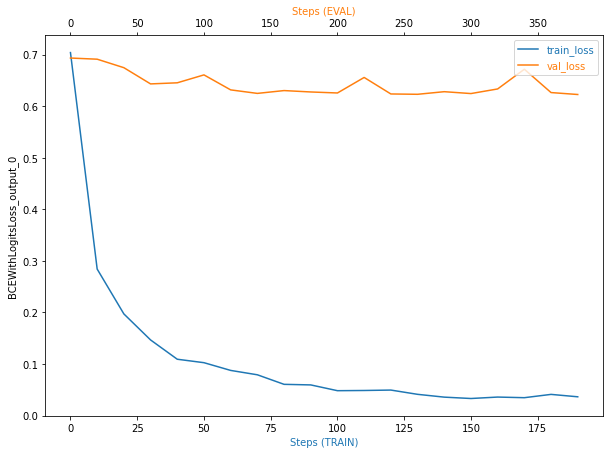

In [16]:
plot_tensor(trial, "BCEWithLogitsLoss_output_0")

In [36]:
#model_location=estimator.model_data
model_location = 's3://sagemaker-us-east-1-481431275718/UNET-IMG-2022-01-02-13-26-11-108/output/model.tar.gz'

In [37]:
model_location

's3://sagemaker-us-east-1-481431275718/UNET-IMG-2022-01-02-13-26-11-108/output/model.tar.gz'

In [38]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

In [39]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [52]:
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='endpoint.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor) 

In [55]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.g4dn.xlarge')

-------!

In [41]:
with open("./data/val/f707d6fbc0cd_08.jpg", "rb") as f:
    payload = f.read()
    
type(payload)

bytes

In [56]:
response=predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
response

InternalFailure: An error occurred (InternalFailure) when calling the InvokeEndpoint operation (reached max retries: 4): An exception occurred while sending request to model. Please contact customer support regarding request b0a2dd66-9695-4fe4-8021-5d0f2358d461.

In [23]:
A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (500) from primary with message "No module named 'smdebug'
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/sagemaker_inference/transformer.py", line 110, in transform
    self.validate_and_initialize(model_dir=model_dir)
  File "/opt/conda/lib/python3.6/site-packages/sagemaker_inference/transformer.py", line 157, in validate_and_initialize
    self._validate_user_module_and_set_functions()
  File "/opt/conda/lib/python3.6/site-packages/sagemaker_inference/transformer.py", line 170, in _validate_user_module_and_set_functions
    user_module = importlib.import_module(user_module_name)
  File "/opt/conda/lib/python3.6/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 994, in _gcd_import
  File "<frozen importlib._bootstrap>", line 971, in _find_and_load
  File "<frozen importlib._bootstrap>", line 955, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 665, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/opt/ml/model/code/training.py", line 16, in <module>
    import smdebug.pytorch as smd
ModuleNotFoundError: No module named 'smdebug'
". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/UNET-IMG-2022-01-02-14-08-59-060 in account 481431275718 for more information.

In [ ]:
plot_tensor(trial, "BCEWithLogitsLoss_output_0")

loaded TRAIN data


In [2]:
!aws s3 cp s3://sagemaker-us-east-1-481431275718/UNET-IMG-2022-01-02-15-42-33-013/output/model.tar.gz ./data

download: s3://sagemaker-us-east-1-481431275718/UNET-IMG-2022-01-02-15-42-33-013/output/model.tar.gz to data/model.tar.gz


model.pth
